## This notebook fine-tunes the DistilBert model for ham/spam classification.

In [ ]:
! pip install evaluate

In [ ]:
! pip install urlextract

In [3]:
import numpy as np
import pandas as pd
import re

import evaluate
import torch
import urlextract
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification, DistilBertTokenizer, DistilBertModel, DataCollatorWithPadding

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

Import pre-processing functions:

In [6]:
from text_processing_functions import unescape_html, remove_urls_by_tld, replace_word_containing, remove_numbers_from_text, remove_currency_from_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Create a Scikit-learn pipeline to run some text pre-processing:

In [7]:
# top-level domains to replace in texts:
REAL_TLDS = ["com", "org.uk", "net", "co.uk", "biz", "edu", "ac", "edu.sg", "tv"]

pre_processer_pipeline = make_pipeline(
    FunctionTransformer(
        unescape_html,
    ),
    FunctionTransformer(
        remove_urls_by_tld,
        kw_args=dict(tld_list=REAL_TLDS, replace_str="http"),
    ),
    FunctionTransformer(
        replace_word_containing,
        kw_args=dict(str_contains_list=["http", "www", "co.uk"], replacement="http"),
    ),
    FunctionTransformer(
        remove_numbers_from_text,
        kw_args=dict(
            min_digits=5,
            max_word_length=20,
            replace_str="phonenumber",
        ),
    ),
    FunctionTransformer(
        remove_currency_from_text,
        kw_args=dict(replace_str="currencystring"),
    )
)

Import the data and use Sklearn to make a stratified split for training and evaluation:

In [106]:
rng = np.random.RandomState(0)
df = pd.read_csv(f"SMSSpamCollection", sep='\t', names=["labels", "text"])
df = df.drop_duplicates(ignore_index=False)
df["labels"] = df["labels"].replace(["ham", "spam"], [0, 1])
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["labels"], test_size=0.3, random_state=rng, stratify=df["labels"])
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


Run the Sklearn pre-processing pipeline:

In [107]:
df_train["text"] = pre_processer_pipeline.fit_transform(df_train["text"])
df_test["text"] = pre_processer_pipeline.transform(df_test["text"])

Convert the dataframes into datasets:

In [108]:
class HamSpamDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        text = row["text"]
        label = row["labels"]

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )

        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'targets': torch.tensor(label, dtype=torch.float32)
        }


In [109]:
CHECKPOINT = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)
MAX_LEN = 256

train_dataset = HamSpamDataset(df=df_train, tokenizer=tokenizer, max_len=MAX_LEN)
test_dataset = HamSpamDataset(df=df_test, tokenizer=tokenizer, max_len=MAX_LEN)

Fine tune the Distilbert base model:

In [110]:
class HamSpamClassifier(torch.nn.Module):
    def __init__(self, model_dim, output_dim):
        super().__init__()
        self.model = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(model_dim, model_dim)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(model_dim, output_dim)

    def forward(self, input_ids, attention_mask):
        output_1 = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output_1[0]
        pooler = last_hidden_state[:, 0, :]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

Function to calculate metrics:

In [111]:
def get_clf_metrics(preds, targets, verbose=False):
    TP = ((preds == 1) & (targets == 1)).sum().item()
    TN = ((preds == 0) & (targets == 0)).sum().item()
    FP = ((preds == 1) & (targets == 0)).sum().item()
    FN = ((preds == 0) & (targets == 1)).sum().item()

    accuracy = (TP + TN) / (TP + TN + FP + FN) if TP + TN + FP + FN > 0 else 0
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    if verbose:
        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 Score: {f1}')


    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


PyTorch training loop:

In [112]:
def train(model, n_epochs, data_loader, learning_rate):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    metric_tracker = {"accuracy": [], "precision": [], "recall": [], "f1": []}

    loss_function = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(n_epochs):
        for i, data in enumerate(data_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float32)

            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            preds = torch.round(torch.sigmoid(outputs))
            n_correct += (preds==targets).sum().item()
            acc_pre_rec_f1 = get_clf_metrics(preds, targets)
            for key in metric_tracker:
                if key in acc_pre_rec_f1:
                    metric_tracker[key].append(acc_pre_rec_f1[key])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i%100 == 0:
                print(f"Epoch {epoch} step {i} loss {loss}")

        f1_avg = np.mean(metric_tracker["f1"])
        print(f"F1 score after Epoch {epoch}: {f1_avg}")
        epoch_loss = tr_loss/nb_tr_steps
        print(f"Training Loss after Epoch {epoch}: {epoch_loss}\n")

    return metric_tracker

In [113]:
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 1e-05

In [114]:
model_0 = HamSpamClassifier(checkpoint=CHECKPOINT, model_dim=768, output_dim=1)
model_0.to(device)

HamSpamClassifier(
  (model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Line

In [115]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
metrics = train(model=model_0, n_epochs=EPOCHS, data_loader=train_loader, learning_rate=LEARNING_RATE)

Epoch 0 step 0 loss 0.8041091561317444
Epoch 0 step 100 loss 0.0472838468849659
Epoch 0 step 200 loss 0.06419757753610611
F1 score after Epoch 0: 0.6285118404385053
Training Loss after Epoch 0: 0.15769029433720044

Epoch 1 step 0 loss 0.017748268321156502
Epoch 1 step 100 loss 0.008950903080403805
Epoch 1 step 200 loss 0.0068129668943583965
F1 score after Epoch 1: 0.754525831414274
Training Loss after Epoch 1: 0.09802512780328318

Epoch 2 step 0 loss 0.005401670932769775
Epoch 2 step 100 loss 0.009082114323973656
Epoch 2 step 200 loss 0.006141296122223139
F1 score after Epoch 2: 0.790888698461904
Training Loss after Epoch 2: 0.07360907300052653



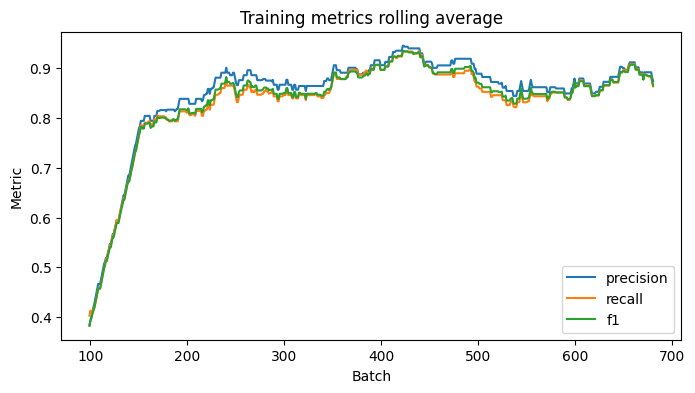

In [116]:
import matplotlib.pyplot as plt

# Plot the metrics from training
precision = pd.Series(metrics["precision"]).rolling(100).mean()
recall = pd.Series(metrics["recall"]).rolling(100).mean()
f1 = pd.Series(metrics["f1"]).rolling(100).mean()

plt.figure(figsize=(8,4))
plt.plot(precision, label="precision")
plt.plot(recall, label="recall")
plt.plot(f1, label="f1")
plt.xlabel("Batch")
plt.ylabel("Metric")
plt.title("Training metrics rolling average")
plt.legend()
plt.show()

Evaluate on the test set:

In [117]:
def valid(model, testing_loader):
    test_targets = []
    test_preds = []
    model.eval()
    with torch.inference_mode():
        for i, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float32)
            outputs = model(ids, mask).squeeze()
            preds = torch.round(torch.sigmoid(outputs))
            test_targets += targets.tolist()
            test_preds += preds.tolist()

    metrics = get_clf_metrics(torch.Tensor(test_preds), torch.Tensor(test_targets))
    acc, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1"]
    print(f"Test metrics:\nPrecision = {precision} \nRecall = {recall} \nF1 score = {f1}")
    return metrics


In [118]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
metrics_test = valid(model=model_0, testing_loader=test_loader)


Test metrics:
Precision = 0.989247311827957 
Recall = 0.9387755102040817 
F1 score = 0.9633507853403142
